<div class="alert alert-block alert-success">
<b>An Introduction to Option:</b> "An option is a derivative of an asset that gives an owner the right but not the obligation to transact the underlying asset at a certain date for a certain price, known as the maturity date and strike price, respectively."
    
<b>An Introduction to Call Option:</b> "The call option gives the buyer the right to buy an asset by a certain date for a certain price. A seller or writer of a call option is obligated to sell the underlying security to the buyer at the agreed price, should the buyer exercise his/her rights on the agreed date."
    
<b>An Introduction to Put Option:</b> "gives the buyer the right to sell the underlying asset by a certain date for a certain price. A seller or writer of a put option is obligated to buy the underlying security from the buyer at the agreed price, should the buyer exercise his/her rights on the agreed date."
</div>

<div class="alert alert-block alert-warning">
The most options that are available are the European Options and American Options. There are other variant as well like Bermudan options or
Asian Options as well. Here in this section , we will discuss about mainly European Options.

<div class="alert alert-block alert-success">
<b>Problem Statement:</b> Consider a two-step binomial tree. A non-dividend paying stock price starts at $$$100,$$ and in each of the two time steps, the stock may go up by 20 percent or go down by 20 percent.We suppose that the risk-free rate is 5 percent per annum and the time to maturity T is 2 years. We would like to find the value of an European put option with a strike price K of $$$102.,$$
</div>

<div class="alert alert-block alert-info">
<b><span style="font-family:Comic Sans MS">Solution:</span></b>
</div>

__Pricing an European Option__

In [1]:
import math

r = 0.05
T = 2
t = T/2
u = 1.2
d = 0.8

q = (math.exp(r*t)-d)/(u-d)

In [2]:
# Calculate the risk-neutral probability 'q' of the stock given in the preceeding example:
print('q is', q)

q is 0.6281777409400603


<div class="alert alert-block alert-info">
<b><span style="font-family:Comic Sans MS">Define the custom function to calculate the European put option price </span></b>
</div>

In [3]:
import math

""" 
Stores common attributes of a stock option 
"""
class StockOption(object):
    def __init__(
        self, S0, K, r=0.05, T=1, N=2, pu=0, pd=0, 
        div=0, sigma=0, is_put=False, is_am=False):
        """
        Initialize the stock option base class.
        Defaults to European call unless specified.

        :param S0: initial stock price
        :param K: strike price
        :param r: risk-free interest rate
        :param T: time to maturity
        :param N: number of time steps
        :param pu: probability at up state
        :param pd: probability at down state
        :param div: Dividend yield
        :param is_put: True for a put option,
                False for a call option
        :param is_am: True for an American option,
                False for a European option
        """
        self.S0 = S0
        self.K = K
        self.r = r
        self.T = T
        self.N = max(1, N)
        self.STs = [] # Declare the stock prices tree

        """ Optional parameters used by derived classes """
        self.pu, self.pd = pu, pd
        self.div = div
        self.sigma = sigma
        self.is_call = not is_put
        self.is_european = not is_am
        
    
    @property
    def dt(self):
        """ Single time step, in years """
        return self.T/float(self.N)
    
    @property
    def df(self):
        """ The discount factor """
        return math.exp(-(self.r-self.div)*self.dt)

In [4]:
import math
import numpy as np
from decimal import Decimal

""" 
Price a European option by the binomial tree model 
"""
class BinEurOpt(StockOption):

    def setup_parameters(self):
        # Required calculations for the model
        self.M = self.N+1  # Number of terminal nodes of tree
        self.u = 1+self.pu  # Expected value in the up state
        self.d = 1-self.pd  # Expected value in the down state
        self.qu = (math.exp(
            (self.r-self.div)*self.dt)-self.d)/(self.u-self.d)
        self.qd = 1-self.qu

    def init_stock_price_tree(self):
        # Initialize terminal price nodes to zeros
        self.STs = np.zeros(self.M)

        # Calculate expected stock prices for each node
        for i in range(self.M):
            self.STs[i] = self.S0 * (self.u**(self.N-i)) * (self.d**i)

    def init_payoffs_tree(self):
        """
        Returns the payoffs when the option 
        expires at terminal nodes
        """ 
        if self.is_call:
            return np.maximum(0, self.STs-self.K)
        else:
            return np.maximum(0, self.K-self.STs)

    def traverse_tree(self, payoffs):
        """
        Starting from the time the option expires, traverse
        backwards and calculate discounted payoffs at each node
        """
        for i in range(self.N):
            payoffs = (payoffs[:-1]*self.qu + 
                       payoffs[1:]*self.qd)*self.df

        return payoffs

    def begin_tree_traversal(self):
        payoffs = self.init_payoffs_tree()
        return self.traverse_tree(payoffs)

    def price(self):
        """ Entry point of the pricing implementation """
        self.setup_parameters()
        self.init_stock_price_tree()
        payoffs = self.begin_tree_traversal()

        # Option value converges to first node
        return payoffs[0]

In [5]:
eu_option = BinEurOpt(100, 102, r=0.05, T=2, N=2, pu=0.2, pd=0.2, is_put=True)

In [6]:
print('The calculated European put option price is:', eu_option.price())

The calculated European put option price is: 7.289744579409192


<div class="alert alert-block alert-info">
<b><span style="font-family:Comic Sans MS">Define the custom function to calculate the American put option price </span></b>
</div>

In [7]:
import math
import numpy as np

""" 
Calculate the Price of a European or American option by the binomial tree 
"""
class BinomialTreeOption(StockOption):

    def setup_parameters(self):
        self.u = 1+self.pu  # Expected value in the up state
        self.d = 1-self.pd  # Expected value in the down state
        self.qu = (math.exp(
            (self.r-self.div)*self.dt)-self.d)/(self.u-self.d)
        self.qd = 1-self.qu

    def init_stock_price_tree(self):
        # Initialize a 2D tree at T=0
        self.STs = [np.array([self.S0])]

        # Simulate the possible stock prices path
        for i in range(self.N):
            prev_branches = self.STs[-1]
            st = np.concatenate(
                (prev_branches*self.u, 
                 [prev_branches[-1]*self.d]))
            self.STs.append(st) # Add nodes at each time step

    def init_payoffs_tree(self):
        if self.is_call:
            return np.maximum(0, self.STs[self.N]-self.K)
        else:
            return np.maximum(0, self.K-self.STs[self.N])

    def check_early_exercise(self, payoffs, node):
        if self.is_call:
            return np.maximum(payoffs, self.STs[node] - self.K)
        else:
            return np.maximum(payoffs, self.K - self.STs[node])

    def traverse_tree(self, payoffs):
        for i in reversed(range(self.N)):
            # The payoffs from NOT exercising the option
            payoffs = (payoffs[:-1]*self.qu + 
                       payoffs[1:]*self.qd)*self.df

            # Payoffs from exercising, for American options
            if not self.is_european:
                payoffs = self.check_early_exercise(payoffs,i)

        return payoffs

    def begin_tree_traversal(self):
        payoffs = self.init_payoffs_tree()
        return self.traverse_tree(payoffs)

    def price(self):
        """  The pricing implementation """
        self.setup_parameters()
        self.init_stock_price_tree()
        payoffs = self.begin_tree_traversal()
        return payoffs[0]

In [8]:
am_option = BinomialTreeOption(100, 102, r=0.05, T=2, N=2, pu=0.2, pd=0.2, is_put=True, is_am=True)

In [9]:
print("The calculated American put option price is:", am_option.price())

The calculated American put option price is: 9.049201805306126


<div class="alert alert-block alert-info">
<b><span style="font-family:Comic Sans MS">Graphical representation of binomial tree model </span></b>
</div>

In [10]:
def binomial_grid(n):
    import networkx as nx, matplotlib.pyplot as plt
    G = nx.Graph()
    for i in range(0, n + 1):
        for j in range(1, i + 2):
            if i < n:
                G.add_edge((i, j), (i + 1, j))
                G.add_edge((i, j), (i + 1, j + 1))

    posG = {}
    for node in G.nodes():
        posG[node] = (
         node[0], n + 2 + node[0] - 2 * node[1])

    nx.draw(G, pos=posG)

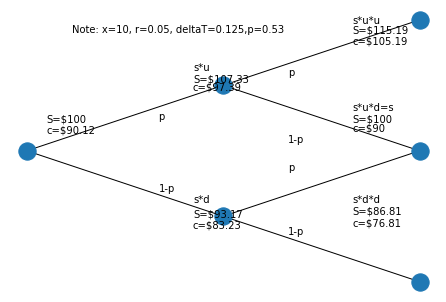

In [11]:
import numpy as np
import matplotlib.pyplot as plt
#
s=100;
x=10;
r=0.05;
sigma=0.2;
T=3./12.;
n=2;
q=0 # q is dividend yield 
deltaT=T/n	# step
u=np.exp(sigma*np.sqrt(deltaT)) 
d=1/u
a=np.exp((r-q)*deltaT) 
p=(a-d)/(u-d)
s_dollar='S=$'
c_dollar='c=$' 
p2=round(p,2)
plt.figtext(0.15,0.91,'Note: x='+str(x)+', r='+str(r)+', deltaT='+str(deltaT)+',p='+str(p2))
plt.figtext(0.35,0.61,'p')
plt.figtext(0.65,0.76,'p')
plt.figtext(0.65,0.43,'p')
plt.figtext(0.35,0.36,'1-p')
plt.figtext(0.65,0.53,'1-p')
plt.figtext(0.65,0.21,'1-p')

# at level 2 
su=round(s*u,2);
suu=round(s*u*u,2) 
sd=round(s*d,2);
sdd=round(s*d*d,2) 
sud=s
c_suu=round(max(suu-x,0),2) 
c_s=round(max(s-x,0),2) 
c_sdd=round(max(sdd-x,0),2) 
plt.figtext(0.8,0.94,'s*u*u') 
plt.figtext(0.8,0.91,s_dollar+str(suu)) 
plt.figtext(0.8,0.87,c_dollar+str(c_suu)) 
plt.figtext(0.8,0.6,s_dollar+str(sud)) 
plt.figtext(0.8,0.64,'s*u*d=s') 
plt.figtext(0.8,0.57,c_dollar+str(c_s)) 
plt.figtext(0.8,0.32,'s*d*d') 
plt.figtext(0.8,0.28,s_dollar+str(sdd)) 
plt.figtext(0.8,0.24,c_dollar+str(c_sdd))

# at level 1
c_01=round((p*c_suu+(1-p)*c_s)*np.exp(-r*deltaT),2) 
c_02=round((p*c_s+(1-p)*c_sdd)*np.exp(-r*deltaT),2)

plt.figtext(0.43,0.78,'s*u') 
plt.figtext(0.43,0.74,s_dollar+str(su)) 
plt.figtext(0.43,0.71,c_dollar+str(c_01)) 
plt.figtext(0.43,0.32,'s*d') 
plt.figtext(0.43,0.27,s_dollar+str(sd)) 
plt.figtext(0.43,0.23,c_dollar+str(c_02))
# at level 0 (today)

c_00=round(p*np.exp(-r*deltaT)*c_01+(1-p)*np.exp(-r*deltaT)*c_02,2) 
plt.figtext(0.09,0.6,s_dollar+str(s)) 
plt.figtext(0.09,0.56,c_dollar+str(c_00)) 
binomial_grid(n)
plt.show()

<div class="alert alert-block alert-info">
<b><span style="font-family:Comic Sans MS">Cox-Ross-Rubinstein binomial tree option pricing model </span></b>
</div>

<div class="alert alert-block alert-warning">
Consider again the two-step binomial tree. 
    
- The non-dividend paying stock has a current price of $$ $100 , $$ 
    
- and a volatility of 35 percent.
    
- Suppose that the risk-free rate is 5 percent per annum 
    
- and the time to maturity T is 2 years 
    
We would like to find the value of an European put option with a strike price K of $102 by the CRR model:

In [20]:
import math

""" 
Price an option by the binomial CRR model 
"""
class BinomialCRROption(BinomialTreeOption):
    def setup_parameters(self):
        self.u = math.exp(self.sigma * math.sqrt(self.dt))
        self.d = 1./self.u
        self.qu = (math.exp((self.r-self.div)*self.dt) - 
                   self.d)/(self.u-self.d)
        self.qd = 1-self.qu

In [21]:
eu_option = BinomialCRROption(100, 102, 
                              r=0.05, 
                              T=2, 
                              N=2, 
                              sigma=0.35, 
                              is_put=True)

In [22]:
print('The calculated European put option price is:', eu_option.price())

The calculated European put option price is: 13.457793676858904


In [23]:
am_option = BinomialCRROption(100, 102, 
                              r=0.05, 
                              T=2, 
                              N=2, 
                              sigma=0.35, 
                              is_put=True, 
                              is_am=True)

In [24]:
print('The calculated American put option price is:', am_option.price())

The calculated American put option price is: 15.894043975009147


<div class="alert alert-block alert-info">
<b><span style="font-family:Comic Sans MS">Leisen-Reimer(LR) binomial tree option pricing model </span></b>
</div>

<details>
<summary>
<i><b>"Binomial Models For Option Valuation - Examining And Improving convergence" By LEISEN & REIMER</b> </i>
<a href="chrome-extension://ohfgljdgelakfkefopgklcohadegdpjf/http://janroman.dhis.org/finance/Binomial%20Models/Leisen%20Reimer.pdf">
Useful Source</a>
</summary>
<img src="img/LR_BIN_MODEL.png"/>
<p></p>
</details>

In [25]:
import math

""" 
Price an option by the Leisen-Reimer tree
"""
class BinomialLROption(BinomialTreeOption):

    def setup_parameters(self):
        odd_N = self.N if (self.N%2 == 0) else (self.N+1)
        d1 = (math.log(self.S0/self.K) +
              ((self.r-self.div) +
               (self.sigma**2)/2.)*self.T)/\
            (self.sigma*math.sqrt(self.T))
        d2 = (math.log(self.S0/self.K) +
              ((self.r-self.div) -
               (self.sigma**2)/2.)*self.T)/\
            (self.sigma * math.sqrt(self.T))

        pbar = self.pp_2_inversion(d1, odd_N)
        self.p = self.pp_2_inversion(d2, odd_N)
        self.u = 1/self.df * pbar/self.p
        self.d = (1/self.df-self.p*self.u)/(1-self.p)
        self.qu = self.p
        self.qd = 1-self.p

    def pp_2_inversion(self, z, n):
        return .5 + math.copysign(1, z)*\
            math.sqrt(.25 - .25*
                math.exp(
                    -((z/(n+1./3.+.1/(n+1)))**2.)*(n+1./6.)
                )
            )

In [26]:
eu_option = BinomialLROption(100, 102, r=0.05, T=2, N=4, sigma=0.35, is_put=True)
am_option = BinomialLROption(100, 102, r=0.05, T=2, N=4, sigma=0.35, is_put=True, is_am=True)

In [27]:
print('The calculated European put option price is:', eu_option.price())
print('The calculated American put option price is:', am_option.price())

The calculated European put option price is: 13.182885304677367
The calculated American put option price is: 14.901491527088913


<div class="alert alert-block alert-success">
<b>An Introduction to Future:</b> "Futures are derivative financial contracts that obligate the parties to transact an asset at a predetermined future date and price. The buyer must purchase or the seller must sell the underlying asset at the set price, regardless of the current market price at the expiration date.
Underlying assets include physical commodities or other financial instruments. Futures contracts detail the quantity of the underlying asset and are standardized to facilitate trading on a futures exchange. Futures can be used for hedging or trade speculation." ---- <b>Investopedia</b>

</div>

<div class="alert alert-block alert-info">
<b><span style="font-family:Comic Sans MS"> Payoff and profit/loss functions for call and put options </span></b>
</div>

<div class="alert alert-block alert-success">
$$ PO (call) = max(S_T - X, 0), $$ 
</div>

In [12]:
# Base custom function to calculate the Payoff for a call option
def payoff_call(sT, X):
    return (sT-X+abs(sT-X))/2

In [13]:
payoff_call(50,55)

0.0

In [14]:
payoff_call(100,55)

45.0

In [15]:
# We can have a array of the first input variable - Stock Price
import numpy as np
X = 50
sT=np.arange(10,100,10)
sT

array([10, 20, 30, 40, 50, 60, 70, 80, 90])

In [16]:
payoff_call(sT,X)

array([ 0.,  0.,  0.,  0.,  0., 10., 20., 30., 40.])

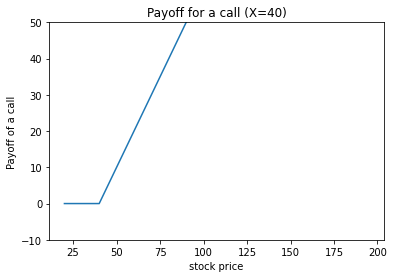

In [17]:
# We can show the relationship grphically as well
import numpy as np
import matplotlib.pyplot as plt
S = np.arange(20,200,5)
X=40
payoff=(abs(S-X)+S-X)/2
plt.ylim(-10,50)
plt.plot(S,payoff)
plt.title("Payoff for a call (X=40)")
plt.xlabel("stock price")
plt.ylabel("Payoff of a call")
plt.show()

<div class="alert alert-block alert-info">
<b><span style="font-family:Comic Sans MS"> Profit and Loss function for call option Buyer and Seller </span></b>
</div>

<div class="alert alert-block alert-success">
For a call option buyer:
$$ Profit/Loss(call) = max(S_T - X, 0) - c, $$ 
and
For a call option seller:
$$ Profit/Loss(call) = c - max(S_T - X, 0), $$
</div>

__Profit and Loss function for a call option__

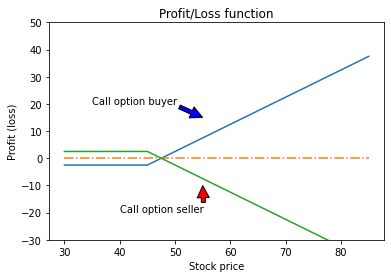

In [18]:
import numpy as np
import matplotlib.pyplot as plt

S = np.arange(30,90,5)
X=45;C=2.5
y=(abs(S-X)+S-X)/2 - C
y2=np.zeros(len(S))
plt.ylim(-30,50)
plt.plot(S,y)
plt.plot(S,y2,'-.')
plt.plot(S,-y)
plt.title("Profit/Loss function")
plt.xlabel('Stock price')
plt.ylabel('Profit (loss)')
plt.annotate('Call option buyer', xy=(55,15), xytext=(35,20),
             arrowprops=dict(facecolor='blue',shrink=0.01),)
plt.annotate('Call option seller', xy=(55,-10), xytext=(40,-20),
             arrowprops=dict(facecolor='red',shrink=0.01),)
plt.show()

__Profit and Loss function for a put option__

<div class="alert alert-block alert-success">
payoff function for a put option:
    
$$ PO(put) = max(X - S_T,0), $$

and For a put option buyer, the profit/loss function is:
    
$$ Profit/Loss(put) = max(X - S_T, 0) - p, $$ 
    
and
    
For a put option seller:
    
$$ Profit/Loss(put) = p - max(X - S_T, 0) $$
</div>

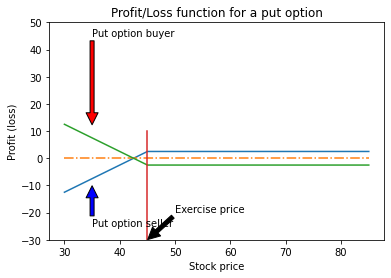

In [19]:
import numpy as np
import matplotlib.pyplot as plt
S = np.arange(30,90,5)
X=45;P=2;C=2.5
y=C-(abs(X-S)+X-S)/2 
y2=np.zeros(len(S)) 
x3=[X, X]
y3=[-30,10]
plt.ylim(-30,50)
plt.plot(S,y) 
plt.plot(S,y2,'-.') 
plt.plot(S,-y) 
plt.plot(x3,y3)
plt.title("Profit/Loss function for a put option") 
plt.xlabel('Stock price')
plt.ylabel('Profit (loss)')
plt.annotate('Put option buyer', xy=(35,12), xytext=(35,45), arrowprops=dict(facecolor='red',shrink=0.01),)
plt.annotate('Put option seller', xy=(35,-10), xytext=(35,-25), arrowprops=dict(facecolor='blue',shrink=0.01),)
plt.annotate('Exercise price', xy=(45,-30), xytext=(50,-20), arrowprops=dict(facecolor='black',shrink=0.01),)
plt.show()

__Relationship between European Option and American Option__

<div class="alert alert-block alert-success">
 
$$ C_a >= C_e  $$

$$ P_a >= P_e  $$

</div>

<div class="alert alert-block alert-info">
<b><span style="font-family:Comic Sans MS"> Hedging Strategy </span></b>
</div>

Please refer to the discussion based on the presentation deck for this section